In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


from utils import *

# Experiment

In [2]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

EXP = 1
def regression_fn(x, w1, w2):
    a = 5 * (w1 + 0.5)
    b = 5 * (w2 - 0.5)
    actual = (
        torch.abs(torch.tanh(((a**2 + b**2)**3 - 4* a**2 * b**2) * x)) + 0.05
    ) * (
        w2 * 
        torch.tanh((w1) * x)
    ) 
#     actual = (
#         torch.tanh((w1**2 + w2**2 - 1) * x)
#     )
#     actual += (
#         w2 * 
#         torch.tanh((w1 -1) * x) * 
#         torch.tanh((w1 + 1)**EXP * x) * 
#         torch.tanh((w2 - (w1 + 1)**2) * x) 
#     )
#     local_minima_term = 0.5 * torch.sqrt(16 - (w1)**2 - ((w2 - 0.6))**2)
#     local_minima_term = 0.0 * torch.tanh((w2 - 0.6)**2 + (w1)**2)
    local_minima_term = 0.0
    return actual + local_minima_term




Using cpu device


Batch size = 1, w0=(-0.25, 0.25)
Finished: w=[-0.557  0.126], w_init=(-0.7491976676656737, -0.6631551580181672), loss=1.215e-04
Finished: w=[-0.282  0.213], w_init=(-0.32066757265526935, -0.26267158364996646), loss=3.572e-05
Finished: w=[-0.21   0.279], w_init=(0.07602559789878056, 0.19223632412309158), loss=3.757e-06
Finished: w=[ 0.377 -0.168], w_init=(0.5895920601756448, 0.5608860452627904), loss=6.004e-05
Finished: w=[ 0.65  -0.115], w_init=(0.8999522712652283, 0.9509054015832454), loss=1.749e-04


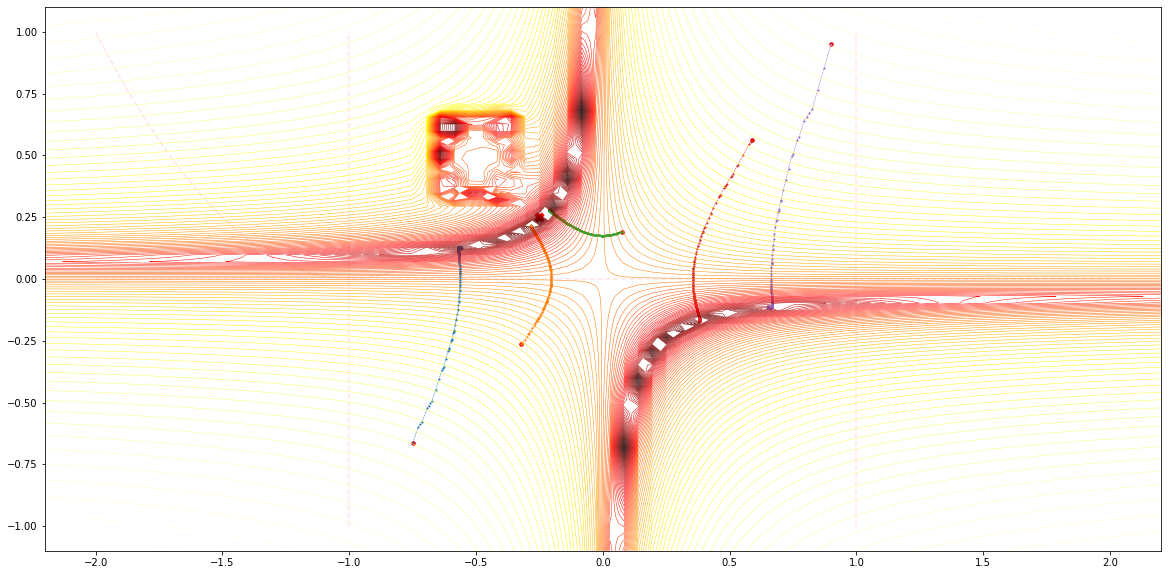

In [4]:
w_true = (-0.25, 0.25)
model_true = Model(*w_true, regression_fn=regression_fn).to(device)

n = 2
X_train =  (torch.rand(n) - 1/2) * 8 # Uniform(-1, 1)
noise = torch.randn(n) * 0.01
y_train = model_true(X_train) + noise

training_data = MyDataset(X_train.detach().numpy(), y_train.detach().numpy())

# n_test = 100
# X_test = (torch.rand(n_test) - 1/2 * 10)
# noise_test = torch.randn(n_test)
# y_test = model_true(X_test) + noise_test
# testing_data = MyDataset(X_test, y_test)

# plt.scatter(X_train.detach().numpy(), y_train.detach().numpy(), s=0.5)


batch_size = max(n // 2, 1)
learning_rate = 0.05
print(f"Batch size = {batch_size}, w0={w_true}")
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# test_dataloader = DataLoader(testing_data, batch_size=batch_size)
epochs = 500
loss_fn = nn.MSELoss()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter([w_true[0]], [w_true[1]], s=80, color="red", marker="X")

ax.vlines([-1, 1], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.1)
ax.hlines([0], xmin=-2, xmax=2, linestyles="dashed", color="red", alpha=0.1)
ax.plot(np.linspace(-2, 0), (np.linspace(-2, 0) + 1)**2, "r--", alpha=0.1)



# initialisation 
# a_vals = [-0.8, -0.1, 0.5, 1.3]
# b_vals = [0.3, 0.1, -0.9]
# init_params = [(a, b) 
#                for a in a_vals
#                for b in b_vals]

# radii = [0.3, 0.4, 1]
# angles = np.random.rand(3) * 2 * np.pi - np.pi
# init_params = [(r * np.cos(a), r * np.sin(a)) for r in radii for a in angles]
init_params = [(x + np.random.rand() / 5, x + np.random.rand() / 5) for x in np.linspace(-.8, 0.8, num=5)]

model_rec = dict()
for (a, b) in init_params:
    ax.scatter([a], [b], s=50, color="red", marker=".")
    model = Model(a, b, regression_fn=regression_fn).to(device)
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimiser, device=device)
    model_rec[(a, b)] = model

    hs = np.array(model.w_history)
    w_pred = hs[-1]
    loss = np.format_float_scientific(model.loss_history[-1], precision=3)
    print(f"Finished: w={np.around(w_pred, 3)}, w_init={(a, b)}, loss={loss}")

    ax.plot(hs[:, 0], hs[:, 1], linestyle='--', marker='o', color=None, linewidth=0.5, markersize=1)
    ax.scatter([w_pred[0]], [w_pred[1]], s=30, color="black", marker=".")

d = 0.00
xmin, xmax = ax.get_xlim()
xmin -= d
xmax += d

ymin, ymax = ax.get_ylim()
ymin -= d
ymax += d

w1_axis = np.linspace(xmin, xmax, num=80)
w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")



dict_keys([(-0.7491976676656737, -0.6631551580181672), (-0.32066757265526935, -0.26267158364996646), (0.07602559789878056, 0.19223632412309158), (0.5895920601756448, 0.5608860452627904), (0.8999522712652283, 0.9509054015832454)])


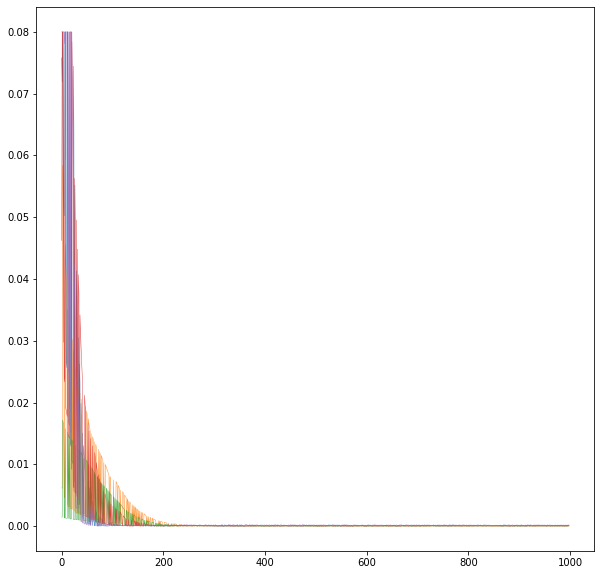

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
print(model_rec.keys())
for key, model in model_rec.items():
    ax.plot(np.clip(model.loss_history[1:], 0, 0.08), alpha=0.8, linewidth=0.5)
# ax.plot(model_rec[(-0.1, -0.9)].loss_history[10:])

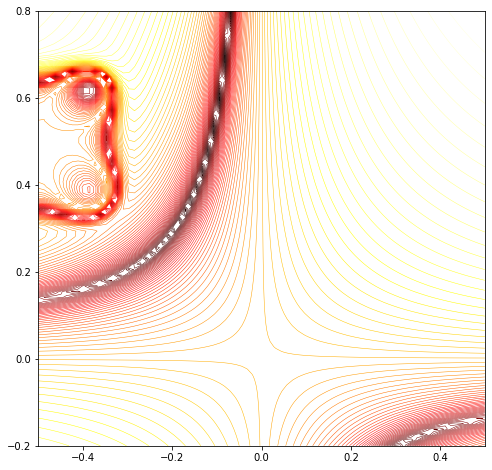

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
w1_axis = np.linspace(-.5, 0.5, num=80)
w2_axis = np.linspace(-.2, .8, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
